In [1]:
IRT_DIMS = 1
DATASET = 'full'    
ITEM_FEATURES = 'False'
ITEM_FEATURES = False if ITEM_FEATURES == 'False' else True

In [2]:
import sys, os, shutil
import pickle
import time
import numpy as np
from utils import (mymode, load_data_heterogeneous, create_data_object_heterogeneous)
import seaborn as sns

from IRT import MIRT_2PL
from Heterogeneous_embedder import EmbedderHeterogeneous, train_embedder_heterogeneous, test_embedder_heterogeneous
from manage_experiments import perform_cross_validation

import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

In [3]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# Initialise
parameters = {
    'df_name': None,
    'epochs': 10000,
    'learning_rate': 0.005,
    'weight_decay': 0,
    'early_stopping': 200,
    'n_splits': 10,
    'device': 'cuda:0',
    'batch_size': 2**14,
    'neighbours': [-1, -1]
    }

if IRT_DIMS > 0:
    parameters['model_type'] = 'IRT'
    parameters['hidden_dims'] = IRT_DIMS
    parameters['lambda1'] = 0
    parameters['lambda2'] = 0
    OUTNAME = 'IRT'
else:
    parameters['model_type'] = 'GNN'
    parameters['hidden_dims'] = [16,8]
    OUTNAME = 'SAGE' 

if ITEM_FEATURES:
    OUTNAME = OUTNAME + '_scales'
    
print(parameters)
print(DATASET)

{'df_name': None, 'epochs': 10000, 'learning_rate': 0.005, 'weight_decay': 0, 'early_stopping': 200, 'n_splits': 10, 'device': 'cuda:0', 'batch_size': 16384, 'neighbours': [50, 50], 'model_type': 'GNN', 'hidden_dims': [16, 8]}
test_matrix


In [5]:
DATA_FILE = 'data/mindsteps_set_' + DATASET
df = load_data_heterogeneous(DATA_FILE)
data, df_student, df_item, df_edge = create_data_object_heterogeneous(df, return_aux_data=True, item_features=ITEM_FEATURES)

(327841, 24)


In [6]:
df.columns

Index(['studentId', 'code', 'motherTongue', 'Gender', 'scale', 'matrix',
       'IRT_difficulty', 'topic', 'responseformat', 'textlength', 'score',
       'age', 'grade', 'viewingTime', 'timestamp', 'useCase', 'assessmentId',
       'ability', 'frequency', 'previous_sessions', 'years_from_start',
       'matdiff', 'matcode', 'domain'],
      dtype='object')

In [7]:
df.head()

,studentId,code,motherTongue,Gender,scale,matrix,IRT_difficulty,topic,responseformat,textlength,...,timestamp,useCase,assessmentId,ability,frequency,previous_sessions,years_from_start,matdiff,matcode,domain
0,0,0,0.0,0.0,dles,D.2.B.1.f,0.268748,Zeitungsartikel,NaN,NaN,...,7.643058e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d
1,0,1,0.0,0.0,dles,D.2.B.1.h,1.217388,Textsorten erkennen,single choice,NaN,...,7.643061e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d
2,0,2,0.0,0.0,dles,D.2.B.1.h,1.584145,Wissenstexte: Mix,single choice,NaN,...,7.845624e-312,ms-kber,E109B3CDD31EDCFE7F48665587372C60A3FAEBB8571544...,2.421279,4.137915,6,1.45,,,d
3,0,3,0.0,0.0,dles,D.2.B.1.h,1.584145,Wissenstexte: Mix,single choice,NaN,...,7.851631e-312,ms-kber,319A0FE3AFDC0A30C4C1B26577B5B19FE66E918A181354...,2.174872,7.432378,11,1.48,,,d
4,0,4,0.0,0.0,dles,D.2.C.1.h,1.172410,Geschichten lang,single choice,NaN,...,7.643059e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d


edge_dim = data['student', 'responds', 'item'].edge_attr.shape[1]
if IRT_DIMS > 0:
    model = MIRT_2PL(IRT_DIMS, edge_dim, data)
else:
    model = EmbedderHeterogeneous( 
        n_students =  data['student'].x.size(0),
        n_items = data['item'].x.size(0),
        student_inchannel = data['student'].x.size(1),
        item_inchannel = data['item'].x.size(1),
        hidden_channels=parameters['hidden_dims'],
        edge_channel=edge_dim,
        metadata=data.metadata()
        ).to(device)
    
model = model.to(device)

In [8]:
output_dict, model = perform_cross_validation(data, parameters, save_embeddings=True, save_subgraph=True, final_fit=True)

0it [00:00, ?it/s]
  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

  0%|          | 1/10000 [00:01<4:38:18,  1.67s/it]


Epoch: 001, Loss: 0.7256, Val: 0.5002, Test: 0.5000




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

  0%|          | 2/10000 [00:02<3:23:34,  1.22s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

  0%|          | 3/10000 [00:03<2:47:29,  1.01s/it]


Epoch: 003, Loss: 0.6626, Val: 0.5002, Test: 0.5000




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

  0%|          | 4/10000 [00:04<2:28:30,  1.12it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

  0%|          | 5/10000 [00:04<2:04:55,  1.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

  0%|          | 6/10000 [00:05<1:59:13,  1.40it/s]


Epoch: 006, Loss: 0.5905, Val: 0.5005, Test: 0.5005




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

  0%|          | 7/10000 [00:05<1:50:00,  1.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

  0%|          | 8/10000 [00:06<1:58:14,  1.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

  0%|          | 9/10000 [00:07<1:47:52,  1.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

  0%|          | 10/10000 [00:07<1:59:47,  1.39it/s]


Epoch: 010, Loss: 0.5312, Val: 0.5021, Test: 0.5062




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

  0%|          | 11/10000 [00:08<2:01:28,  1.37it/s]


Epoch: 011, Loss: 0.5233, Val: 0.5029, Test: 0.5091




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

  0%|          | 12/10000 [00:09<1:54:10,  1.46it/s]


Epoch: 012, Loss: 0.5168, Val: 0.5117, Test: 0.5151




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

  0%|          | 13/10000 [00:10<2:09:12,  1.29it/s]


Epoch: 013, Loss: 0.5129, Val: 0.5138, Test: 0.5152




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

  0%|          | 14/10000 [00:10<1:58:40,  1.40it/s]


Epoch: 014, Loss: 0.5105, Val: 0.5172, Test: 0.5180




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

  0%|          | 15/10000 [00:11<1:51:22,  1.49it/s]


Epoch: 015, Loss: 0.5094, Val: 0.5192, Test: 0.5155




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

  0%|          | 16/10000 [00:11<1:47:21,  1.55it/s]


Epoch: 016, Loss: 0.5096, Val: 0.5220, Test: 0.5164




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

  0%|          | 17/10000 [00:12<1:45:11,  1.58it/s]


Epoch: 017, Loss: 0.5100, Val: 0.5248, Test: 0.5148




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

  0%|          | 18/10000 [00:13<1:50:33,  1.50it/s]


Epoch: 018, Loss: 0.5115, Val: 0.5264, Test: 0.5186




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

  0%|          | 19/10000 [00:14<1:59:18,  1.39it/s]


Epoch: 019, Loss: 0.5120, Val: 0.5294, Test: 0.5186




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

  0%|          | 20/10000 [00:14<1:50:55,  1.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

  0%|          | 21/10000 [00:15<1:53:47,  1.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

  0%|          | 22/10000 [00:15<1:44:50,  1.59it/s]


Epoch: 022, Loss: 0.5135, Val: 0.5311, Test: 0.5236




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

  0%|          | 23/10000 [00:16<1:47:43,  1.54it/s]


Epoch: 023, Loss: 0.5131, Val: 0.5314, Test: 0.5250




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

  0%|          | 24/10000 [00:17<1:39:04,  1.68it/s]


Epoch: 024, Loss: 0.5123, Val: 0.5327, Test: 0.5275




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

  0%|          | 25/10000 [00:17<1:44:15,  1.59it/s]


Epoch: 025, Loss: 0.5110, Val: 0.5336, Test: 0.5306




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

  0%|          | 26/10000 [00:18<1:39:56,  1.66it/s]


Epoch: 026, Loss: 0.5090, Val: 0.5337, Test: 0.5301




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

  0%|          | 27/10000 [00:18<1:35:46,  1.74it/s]


Epoch: 027, Loss: 0.5071, Val: 0.5355, Test: 0.5308




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

  0%|          | 28/10000 [00:19<1:36:30,  1.72it/s]


Epoch: 028, Loss: 0.5050, Val: 0.5373, Test: 0.5328




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

  0%|          | 29/10000 [00:20<1:42:15,  1.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

  0%|          | 30/10000 [00:20<1:43:33,  1.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

  0%|          | 31/10000 [00:21<1:42:55,  1.61it/s]


Epoch: 031, Loss: 0.4987, Val: 0.5375, Test: 0.5374




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

  0%|          | 32/10000 [00:22<1:45:33,  1.57it/s]


Epoch: 032, Loss: 0.4965, Val: 0.5382, Test: 0.5409




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

  0%|          | 33/10000 [00:22<1:56:11,  1.43it/s]


Epoch: 033, Loss: 0.4946, Val: 0.5394, Test: 0.5425




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

  0%|          | 34/10000 [00:23<1:59:50,  1.39it/s]


Epoch: 034, Loss: 0.4930, Val: 0.5411, Test: 0.5440




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

  0%|          | 35/10000 [00:24<1:53:21,  1.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

  0%|          | 36/10000 [00:25<2:07:22,  1.30it/s]


Epoch: 036, Loss: 0.4899, Val: 0.5420, Test: 0.5453




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

  0%|          | 37/10000 [00:26<2:32:09,  1.09it/s]


Epoch: 037, Loss: 0.4885, Val: 0.5446, Test: 0.5431




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

  0%|          | 38/10000 [00:27<2:23:57,  1.15it/s]


Epoch: 038, Loss: 0.4879, Val: 0.5453, Test: 0.5448




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

  0%|          | 39/10000 [00:27<2:11:35,  1.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

  0%|          | 40/10000 [00:28<2:12:29,  1.25it/s]


Epoch: 040, Loss: 0.4851, Val: 0.5470, Test: 0.5472




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

  0%|          | 41/10000 [00:29<2:11:19,  1.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

  0%|          | 42/10000 [00:30<2:08:21,  1.29it/s]


Epoch: 042, Loss: 0.4827, Val: 0.5476, Test: 0.5486




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

  0%|          | 43/10000 [00:31<2:09:12,  1.28it/s]


Epoch: 043, Loss: 0.4810, Val: 0.5481, Test: 0.5510




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

  0%|          | 44/10000 [00:31<2:11:36,  1.26it/s]


Epoch: 044, Loss: 0.4798, Val: 0.5490, Test: 0.5523




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

  0%|          | 45/10000 [00:32<2:03:30,  1.34it/s]


Epoch: 045, Loss: 0.4781, Val: 0.5508, Test: 0.5543




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

  0%|          | 46/10000 [00:33<2:13:19,  1.24it/s]


Epoch: 046, Loss: 0.4772, Val: 0.5524, Test: 0.5550




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

  0%|          | 47/10000 [00:34<2:11:35,  1.26it/s]


Epoch: 047, Loss: 0.4756, Val: 0.5549, Test: 0.5559




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

  0%|          | 48/10000 [00:34<2:02:16,  1.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

  0%|          | 49/10000 [00:35<2:07:30,  1.30it/s]


Epoch: 049, Loss: 0.4723, Val: 0.5549, Test: 0.5584




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

  0%|          | 50/10000 [00:36<2:01:49,  1.36it/s]


Epoch: 050, Loss: 0.4703, Val: 0.5578, Test: 0.5606




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

  1%|          | 51/10000 [00:36<1:59:20,  1.39it/s]


Epoch: 051, Loss: 0.4684, Val: 0.5593, Test: 0.5610




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

  1%|          | 52/10000 [00:37<2:04:00,  1.34it/s]


Epoch: 052, Loss: 0.4667, Val: 0.5614, Test: 0.5619




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

  1%|          | 53/10000 [00:38<2:10:29,  1.27it/s]


Epoch: 053, Loss: 0.4648, Val: 0.5624, Test: 0.5629




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

  1%|          | 54/10000 [00:39<2:11:04,  1.26it/s]


Epoch: 054, Loss: 0.4634, Val: 0.5634, Test: 0.5635




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

  1%|          | 55/10000 [00:40<2:18:07,  1.20it/s]


Epoch: 055, Loss: 0.4622, Val: 0.5652, Test: 0.5643




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

  1%|          | 56/10000 [00:41<2:09:32,  1.28it/s]


Epoch: 056, Loss: 0.4608, Val: 0.5655, Test: 0.5651




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

  1%|          | 57/10000 [00:42<2:18:01,  1.20it/s]


Epoch: 057, Loss: 0.4589, Val: 0.5681, Test: 0.5667




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

  1%|          | 58/10000 [00:42<2:23:18,  1.16it/s]


Epoch: 058, Loss: 0.4566, Val: 0.5688, Test: 0.5664




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

  1%|          | 59/10000 [00:43<2:05:44,  1.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

  1%|          | 60/10000 [00:44<2:16:25,  1.21it/s]


Epoch: 060, Loss: 0.4542, Val: 0.5693, Test: 0.5674




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

  1%|          | 61/10000 [00:45<2:10:19,  1.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

  1%|          | 62/10000 [00:45<1:57:36,  1.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

  1%|          | 63/10000 [00:46<1:51:54,  1.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

  1%|          | 64/10000 [00:46<1:50:44,  1.50it/s]


Epoch: 064, Loss: 0.4473, Val: 0.5693, Test: 0.5666




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

  1%|          | 65/10000 [00:47<1:57:51,  1.41it/s]


Epoch: 065, Loss: 0.4457, Val: 0.5694, Test: 0.5680




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

  1%|          | 66/10000 [00:48<1:57:55,  1.40it/s]


Epoch: 066, Loss: 0.4451, Val: 0.5704, Test: 0.5671




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

  1%|          | 67/10000 [00:49<2:09:59,  1.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

  1%|          | 68/10000 [00:50<2:07:59,  1.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

  1%|          | 69/10000 [00:50<2:01:47,  1.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

  1%|          | 70/10000 [00:51<1:51:17,  1.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

  1%|          | 71/10000 [00:52<1:52:17,  1.47it/s]


Epoch: 071, Loss: 0.4377, Val: 0.5708, Test: 0.5681




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

  1%|          | 72/10000 [00:52<2:01:44,  1.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

  1%|          | 73/10000 [00:53<2:10:15,  1.27it/s]


Epoch: 073, Loss: 0.4354, Val: 0.5711, Test: 0.5669




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

  1%|          | 74/10000 [00:54<2:12:13,  1.25it/s]


Epoch: 074, Loss: 0.4343, Val: 0.5713, Test: 0.5677




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

  1%|          | 75/10000 [00:55<2:03:23,  1.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

  1%|          | 76/10000 [00:55<2:02:08,  1.35it/s]


Epoch: 076, Loss: 0.4310, Val: 0.5720, Test: 0.5696




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

  1%|          | 77/10000 [00:56<2:17:00,  1.21it/s]


Epoch: 077, Loss: 0.4307, Val: 0.5728, Test: 0.5697




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

  1%|          | 78/10000 [00:57<2:22:34,  1.16it/s]


Epoch: 078, Loss: 0.4289, Val: 0.5739, Test: 0.5702




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

  1%|          | 79/10000 [00:58<2:19:05,  1.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

  1%|          | 80/10000 [00:59<2:18:30,  1.19it/s]


Epoch: 080, Loss: 0.4273, Val: 0.5744, Test: 0.5714




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

  1%|          | 81/10000 [01:00<2:22:36,  1.16it/s]


Epoch: 081, Loss: 0.4260, Val: 0.5748, Test: 0.5725




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

  1%|          | 82/10000 [01:01<2:35:38,  1.06it/s]


Epoch: 082, Loss: 0.4250, Val: 0.5755, Test: 0.5727




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]



Epoch: 083, Loss: 0.4239, Val: 0.5764, Test: 0.5735



  1%|          | 83/10000 [01:02<2:45:45,  1.00s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

  1%|          | 84/10000 [01:03<2:37:42,  1.05it/s]


Epoch: 084, Loss: 0.4230, Val: 0.5764, Test: 0.5745




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

  1%|          | 85/10000 [01:04<2:23:12,  1.15it/s]


Epoch: 085, Loss: 0.4215, Val: 0.5767, Test: 0.5754




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

  1%|          | 86/10000 [01:05<2:27:59,  1.12it/s]


Epoch: 086, Loss: 0.4214, Val: 0.5774, Test: 0.5759




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

  1%|          | 87/10000 [01:05<2:21:20,  1.17it/s]


Epoch: 087, Loss: 0.4204, Val: 0.5787, Test: 0.5766




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

  1%|          | 88/10000 [01:07<2:39:44,  1.03it/s]


Epoch: 088, Loss: 0.4195, Val: 0.5788, Test: 0.5782




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

  1%|          | 89/10000 [01:07<2:22:57,  1.16it/s]


Epoch: 089, Loss: 0.4193, Val: 0.5795, Test: 0.5788




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

  1%|          | 90/10000 [01:08<2:20:35,  1.17it/s]


Epoch: 090, Loss: 0.4180, Val: 0.5810, Test: 0.5792




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

  1%|          | 91/10000 [01:09<2:18:05,  1.20it/s]


Epoch: 091, Loss: 0.4167, Val: 0.5814, Test: 0.5793




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

  1%|          | 92/10000 [01:10<2:19:52,  1.18it/s]


Epoch: 092, Loss: 0.4163, Val: 0.5821, Test: 0.5807




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

  1%|          | 93/10000 [01:11<2:29:45,  1.10it/s]


Epoch: 093, Loss: 0.4159, Val: 0.5833, Test: 0.5817




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

  1%|          | 94/10000 [01:12<2:30:41,  1.10it/s]


Epoch: 094, Loss: 0.4149, Val: 0.5839, Test: 0.5831




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

  1%|          | 95/10000 [01:13<2:22:55,  1.16it/s]


Epoch: 095, Loss: 0.4141, Val: 0.5847, Test: 0.5845




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

  1%|          | 96/10000 [01:14<2:30:45,  1.09it/s]


Epoch: 096, Loss: 0.4133, Val: 0.5852, Test: 0.5849




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

  1%|          | 97/10000 [01:14<2:20:15,  1.18it/s]


Epoch: 097, Loss: 0.4132, Val: 0.5855, Test: 0.5850




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

  1%|          | 98/10000 [01:15<2:23:52,  1.15it/s]


Epoch: 098, Loss: 0.4124, Val: 0.5861, Test: 0.5858




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

  1%|          | 99/10000 [01:16<2:14:55,  1.22it/s]


Epoch: 099, Loss: 0.4123, Val: 0.5864, Test: 0.5858




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

  1%|          | 100/10000 [01:17<2:12:34,  1.24it/s]


Epoch: 100, Loss: 0.4114, Val: 0.5865, Test: 0.5864




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

  1%|          | 101/10000 [01:17<2:05:57,  1.31it/s]


Epoch: 101, Loss: 0.4098, Val: 0.5869, Test: 0.5861




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

  1%|          | 102/10000 [01:18<2:08:09,  1.29it/s]


Epoch: 102, Loss: 0.4100, Val: 0.5870, Test: 0.5868




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

  1%|          | 103/10000 [01:19<2:04:27,  1.33it/s]


Epoch: 103, Loss: 0.4091, Val: 0.5873, Test: 0.5869




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

  1%|          | 104/10000 [01:20<2:00:13,  1.37it/s]


Epoch: 104, Loss: 0.4086, Val: 0.5879, Test: 0.5879




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

  1%|          | 105/10000 [01:20<1:51:30,  1.48it/s]


Epoch: 105, Loss: 0.4088, Val: 0.5884, Test: 0.5882




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

  1%|          | 106/10000 [01:21<1:43:29,  1.59it/s]


Epoch: 106, Loss: 0.4081, Val: 0.5889, Test: 0.5878




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

  1%|          | 107/10000 [01:21<1:52:48,  1.46it/s]


Epoch: 107, Loss: 0.4076, Val: 0.5896, Test: 0.5886




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

  1%|          | 108/10000 [01:22<1:45:49,  1.56it/s]


Epoch: 108, Loss: 0.4077, Val: 0.5896, Test: 0.5887




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

  1%|          | 109/10000 [01:22<1:35:27,  1.73it/s]


Epoch: 109, Loss: 0.4060, Val: 0.5902, Test: 0.5891




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

  1%|          | 110/10000 [01:23<1:32:28,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

  1%|          | 111/10000 [01:23<1:32:10,  1.79it/s]


Epoch: 111, Loss: 0.4056, Val: 0.5905, Test: 0.5899




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

  1%|          | 112/10000 [01:24<1:28:17,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

  1%|          | 113/10000 [01:24<1:25:19,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

  1%|          | 114/10000 [01:25<1:21:03,  2.03it/s]


Epoch: 114, Loss: 0.4046, Val: 0.5906, Test: 0.5916




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

  1%|          | 115/10000 [01:25<1:18:37,  2.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

  1%|          | 116/10000 [01:26<1:15:56,  2.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

  1%|          | 117/10000 [01:26<1:16:20,  2.16it/s]


Epoch: 117, Loss: 0.4031, Val: 0.5909, Test: 0.5943




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

  1%|          | 118/10000 [01:27<1:25:05,  1.94it/s]


Epoch: 118, Loss: 0.4025, Val: 0.5916, Test: 0.5952




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

  1%|          | 119/10000 [01:27<1:21:44,  2.01it/s]


Epoch: 119, Loss: 0.4027, Val: 0.5925, Test: 0.5957




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

  1%|          | 120/10000 [01:28<1:17:26,  2.13it/s]


Epoch: 120, Loss: 0.4023, Val: 0.5931, Test: 0.5955




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

  1%|          | 121/10000 [01:28<1:16:19,  2.16it/s]


Epoch: 121, Loss: 0.4019, Val: 0.5932, Test: 0.5955




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

  1%|          | 122/10000 [01:29<1:13:36,  2.24it/s]


Epoch: 122, Loss: 0.4014, Val: 0.5937, Test: 0.5962




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

  1%|          | 123/10000 [01:29<1:18:20,  2.10it/s]


Epoch: 123, Loss: 0.4014, Val: 0.5945, Test: 0.5974




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

  1%|          | 124/10000 [01:30<1:20:13,  2.05it/s]


Epoch: 124, Loss: 0.4006, Val: 0.5954, Test: 0.5976




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

  1%|▏         | 125/10000 [01:30<1:20:01,  2.06it/s]


Epoch: 125, Loss: 0.4002, Val: 0.5963, Test: 0.5975




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

  1%|▏         | 126/10000 [01:31<1:18:44,  2.09it/s]


Epoch: 126, Loss: 0.4002, Val: 0.5967, Test: 0.5989




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

  1%|▏         | 127/10000 [01:31<1:23:20,  1.97it/s]


Epoch: 127, Loss: 0.4004, Val: 0.5974, Test: 0.5993




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

  1%|▏         | 128/10000 [01:32<1:22:50,  1.99it/s]


Epoch: 128, Loss: 0.4005, Val: 0.5981, Test: 0.5994




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

  1%|▏         | 129/10000 [01:32<1:21:17,  2.02it/s]


Epoch: 129, Loss: 0.3990, Val: 0.5983, Test: 0.6001




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

  1%|▏         | 130/10000 [01:33<1:22:19,  2.00it/s]


Epoch: 130, Loss: 0.3996, Val: 0.5991, Test: 0.6010




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

  1%|▏         | 131/10000 [01:33<1:30:21,  1.82it/s]


Epoch: 131, Loss: 0.3981, Val: 0.5997, Test: 0.6006




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

  1%|▏         | 132/10000 [01:34<1:37:47,  1.68it/s]


Epoch: 132, Loss: 0.3987, Val: 0.6000, Test: 0.6016




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

  1%|▏         | 133/10000 [01:34<1:32:50,  1.77it/s]


Epoch: 133, Loss: 0.3980, Val: 0.6008, Test: 0.6019




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

  1%|▏         | 134/10000 [01:35<1:32:47,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

  1%|▏         | 135/10000 [01:36<1:35:54,  1.71it/s]


Epoch: 135, Loss: 0.3978, Val: 0.6008, Test: 0.6025




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

  1%|▏         | 136/10000 [01:36<1:41:28,  1.62it/s]


Epoch: 136, Loss: 0.3973, Val: 0.6015, Test: 0.6035




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

  1%|▏         | 137/10000 [01:37<1:37:53,  1.68it/s]


Epoch: 137, Loss: 0.3974, Val: 0.6024, Test: 0.6043




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

  1%|▏         | 138/10000 [01:37<1:37:48,  1.68it/s]


Epoch: 138, Loss: 0.3975, Val: 0.6025, Test: 0.6046




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

  1%|▏         | 139/10000 [01:38<1:32:19,  1.78it/s]


Epoch: 139, Loss: 0.3973, Val: 0.6028, Test: 0.6052




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

  1%|▏         | 140/10000 [01:39<1:37:06,  1.69it/s]


Epoch: 140, Loss: 0.3973, Val: 0.6031, Test: 0.6059




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

  1%|▏         | 141/10000 [01:39<1:41:12,  1.62it/s]


Epoch: 141, Loss: 0.3970, Val: 0.6031, Test: 0.6060




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

  1%|▏         | 142/10000 [01:40<1:36:54,  1.70it/s]


Epoch: 142, Loss: 0.3966, Val: 0.6037, Test: 0.6058




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

  1%|▏         | 143/10000 [01:40<1:41:33,  1.62it/s]


Epoch: 143, Loss: 0.3962, Val: 0.6042, Test: 0.6065




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

  1%|▏         | 144/10000 [01:41<1:42:29,  1.60it/s]


Epoch: 144, Loss: 0.3968, Val: 0.6046, Test: 0.6069




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

  1%|▏         | 145/10000 [01:42<1:42:59,  1.59it/s]


Epoch: 145, Loss: 0.3957, Val: 0.6048, Test: 0.6069




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

  1%|▏         | 146/10000 [01:42<1:41:53,  1.61it/s]


Epoch: 146, Loss: 0.3962, Val: 0.6056, Test: 0.6065




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

  1%|▏         | 147/10000 [01:43<1:39:14,  1.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

  1%|▏         | 148/10000 [01:43<1:35:54,  1.71it/s]


Epoch: 148, Loss: 0.3954, Val: 0.6060, Test: 0.6072




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

  1%|▏         | 149/10000 [01:44<1:30:51,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

  2%|▏         | 150/10000 [01:44<1:26:00,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

  2%|▏         | 151/10000 [01:45<1:27:40,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

  2%|▏         | 152/10000 [01:46<1:29:10,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

  2%|▏         | 153/10000 [01:46<1:27:30,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

  2%|▏         | 154/10000 [01:47<1:27:52,  1.87it/s]


Epoch: 154, Loss: 0.3954, Val: 0.6063, Test: 0.6095




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

  2%|▏         | 155/10000 [01:47<1:31:28,  1.79it/s]


Epoch: 155, Loss: 0.3949, Val: 0.6071, Test: 0.6105




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

  2%|▏         | 156/10000 [01:48<1:39:07,  1.66it/s]


Epoch: 156, Loss: 0.3945, Val: 0.6077, Test: 0.6114




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

  2%|▏         | 157/10000 [01:48<1:36:16,  1.70it/s]


Epoch: 157, Loss: 0.3946, Val: 0.6081, Test: 0.6123




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

  2%|▏         | 158/10000 [01:49<1:32:49,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

  2%|▏         | 159/10000 [01:50<1:34:16,  1.74it/s]


Epoch: 159, Loss: 0.3943, Val: 0.6086, Test: 0.6134




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

  2%|▏         | 160/10000 [01:50<1:29:01,  1.84it/s]


Epoch: 160, Loss: 0.3940, Val: 0.6089, Test: 0.6132




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

  2%|▏         | 161/10000 [01:51<1:27:04,  1.88it/s]


Epoch: 161, Loss: 0.3941, Val: 0.6095, Test: 0.6135




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

  2%|▏         | 162/10000 [01:51<1:26:14,  1.90it/s]


Epoch: 162, Loss: 0.3942, Val: 0.6109, Test: 0.6133




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

  2%|▏         | 163/10000 [01:52<1:25:20,  1.92it/s]


Epoch: 163, Loss: 0.3935, Val: 0.6109, Test: 0.6136




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

  2%|▏         | 164/10000 [01:52<1:25:09,  1.93it/s]


Epoch: 164, Loss: 0.3937, Val: 0.6116, Test: 0.6139




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

  2%|▏         | 165/10000 [01:53<1:28:48,  1.85it/s]


Epoch: 165, Loss: 0.3938, Val: 0.6119, Test: 0.6143




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

  2%|▏         | 166/10000 [01:53<1:31:10,  1.80it/s]


Epoch: 166, Loss: 0.3937, Val: 0.6126, Test: 0.6149




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

  2%|▏         | 167/10000 [01:54<1:30:51,  1.80it/s]


Epoch: 167, Loss: 0.3936, Val: 0.6134, Test: 0.6151




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

  2%|▏         | 168/10000 [01:54<1:31:53,  1.78it/s]


Epoch: 168, Loss: 0.3929, Val: 0.6144, Test: 0.6153




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

  2%|▏         | 169/10000 [01:55<1:32:11,  1.78it/s]


Epoch: 169, Loss: 0.3933, Val: 0.6147, Test: 0.6164




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

  2%|▏         | 170/10000 [01:56<1:32:30,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

  2%|▏         | 171/10000 [01:56<1:33:37,  1.75it/s]


Epoch: 171, Loss: 0.3929, Val: 0.6149, Test: 0.6181




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

  2%|▏         | 172/10000 [01:57<1:34:11,  1.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

  2%|▏         | 173/10000 [01:57<1:36:54,  1.69it/s]


Epoch: 173, Loss: 0.3929, Val: 0.6153, Test: 0.6188




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

  2%|▏         | 174/10000 [01:58<1:36:29,  1.70it/s]


Epoch: 174, Loss: 0.3929, Val: 0.6158, Test: 0.6193




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

  2%|▏         | 175/10000 [01:58<1:35:59,  1.71it/s]


Epoch: 175, Loss: 0.3929, Val: 0.6160, Test: 0.6198




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

  2%|▏         | 176/10000 [01:59<1:34:51,  1.73it/s]


Epoch: 176, Loss: 0.3929, Val: 0.6166, Test: 0.6197




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

  2%|▏         | 177/10000 [02:00<1:34:25,  1.73it/s]


Epoch: 177, Loss: 0.3929, Val: 0.6168, Test: 0.6205




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

  2%|▏         | 178/10000 [02:00<1:35:01,  1.72it/s]


Epoch: 178, Loss: 0.3925, Val: 0.6175, Test: 0.6213




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

  2%|▏         | 179/10000 [02:01<1:34:59,  1.72it/s]


Epoch: 179, Loss: 0.3926, Val: 0.6183, Test: 0.6219




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

  2%|▏         | 180/10000 [02:01<1:33:41,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

  2%|▏         | 181/10000 [02:02<1:33:13,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

  2%|▏         | 182/10000 [02:03<1:34:56,  1.72it/s]


Epoch: 182, Loss: 0.3920, Val: 0.6189, Test: 0.6239




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

  2%|▏         | 183/10000 [02:03<1:34:55,  1.72it/s]


Epoch: 183, Loss: 0.3921, Val: 0.6190, Test: 0.6233




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

  2%|▏         | 184/10000 [02:04<1:36:29,  1.70it/s]


Epoch: 184, Loss: 0.3918, Val: 0.6201, Test: 0.6235




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

  2%|▏         | 185/10000 [02:04<1:38:36,  1.66it/s]


Epoch: 185, Loss: 0.3919, Val: 0.6205, Test: 0.6241




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

  2%|▏         | 186/10000 [02:05<1:39:14,  1.65it/s]


Epoch: 186, Loss: 0.3925, Val: 0.6208, Test: 0.6251




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

  2%|▏         | 187/10000 [02:06<1:40:23,  1.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

  2%|▏         | 188/10000 [02:06<1:35:32,  1.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

  2%|▏         | 189/10000 [02:07<1:37:11,  1.68it/s]


Epoch: 189, Loss: 0.3918, Val: 0.6210, Test: 0.6268




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

  2%|▏         | 190/10000 [02:07<1:37:35,  1.68it/s]


Epoch: 190, Loss: 0.3916, Val: 0.6211, Test: 0.6272




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

  2%|▏         | 191/10000 [02:08<1:39:48,  1.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

  2%|▏         | 192/10000 [02:09<1:37:36,  1.67it/s]


Epoch: 192, Loss: 0.3912, Val: 0.6222, Test: 0.6277




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

  2%|▏         | 193/10000 [02:09<1:39:53,  1.64it/s]


Epoch: 193, Loss: 0.3917, Val: 0.6223, Test: 0.6290




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

  2%|▏         | 194/10000 [02:10<1:42:08,  1.60it/s]


Epoch: 194, Loss: 0.3914, Val: 0.6229, Test: 0.6287




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

  2%|▏         | 195/10000 [02:10<1:40:51,  1.62it/s]


Epoch: 195, Loss: 0.3918, Val: 0.6234, Test: 0.6291




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

  2%|▏         | 196/10000 [02:11<1:38:41,  1.66it/s]


Epoch: 196, Loss: 0.3917, Val: 0.6235, Test: 0.6292




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

  2%|▏         | 197/10000 [02:12<1:37:15,  1.68it/s]


Epoch: 197, Loss: 0.3915, Val: 0.6237, Test: 0.6304




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

  2%|▏         | 198/10000 [02:12<1:39:15,  1.65it/s]


Epoch: 198, Loss: 0.3911, Val: 0.6247, Test: 0.6304




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

  2%|▏         | 199/10000 [02:13<1:38:17,  1.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

  2%|▏         | 200/10000 [02:13<1:33:12,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

  2%|▏         | 201/10000 [02:14<1:29:50,  1.82it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

  2%|▏         | 202/10000 [02:14<1:25:54,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

  2%|▏         | 203/10000 [02:15<1:25:19,  1.91it/s]


Epoch: 203, Loss: 0.3910, Val: 0.6256, Test: 0.6317




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

  2%|▏         | 204/10000 [02:15<1:23:47,  1.95it/s]


Epoch: 204, Loss: 0.3912, Val: 0.6265, Test: 0.6317




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

  2%|▏         | 205/10000 [02:16<1:26:40,  1.88it/s]


Epoch: 205, Loss: 0.3915, Val: 0.6280, Test: 0.6319




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

  2%|▏         | 206/10000 [02:16<1:28:37,  1.84it/s]


Epoch: 206, Loss: 0.3912, Val: 0.6287, Test: 0.6331




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

  2%|▏         | 207/10000 [02:17<1:30:56,  1.79it/s]


Epoch: 207, Loss: 0.3911, Val: 0.6298, Test: 0.6335




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

  2%|▏         | 208/10000 [02:18<1:32:37,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

  2%|▏         | 209/10000 [02:18<1:33:53,  1.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

  2%|▏         | 210/10000 [02:19<1:33:06,  1.75it/s]


Epoch: 210, Loss: 0.3912, Val: 0.6300, Test: 0.6349




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

  2%|▏         | 211/10000 [02:19<1:33:37,  1.74it/s]


Epoch: 211, Loss: 0.3909, Val: 0.6308, Test: 0.6348




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

  2%|▏         | 212/10000 [02:20<1:38:42,  1.65it/s]


Epoch: 212, Loss: 0.3913, Val: 0.6311, Test: 0.6354




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

  2%|▏         | 213/10000 [02:21<1:42:46,  1.59it/s]


Epoch: 213, Loss: 0.3910, Val: 0.6323, Test: 0.6349




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

  2%|▏         | 214/10000 [02:21<1:48:18,  1.51it/s]


Epoch: 214, Loss: 0.3909, Val: 0.6323, Test: 0.6360




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

  2%|▏         | 215/10000 [02:22<1:46:51,  1.53it/s]


Epoch: 215, Loss: 0.3910, Val: 0.6332, Test: 0.6363




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

  2%|▏         | 216/10000 [02:23<1:46:21,  1.53it/s]


Epoch: 216, Loss: 0.3906, Val: 0.6338, Test: 0.6370




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

  2%|▏         | 217/10000 [02:23<1:45:03,  1.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

  2%|▏         | 218/10000 [02:24<1:41:59,  1.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

  2%|▏         | 219/10000 [02:25<1:41:23,  1.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

  2%|▏         | 220/10000 [02:25<1:39:59,  1.63it/s]


Epoch: 220, Loss: 0.3906, Val: 0.6344, Test: 0.6397




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

  2%|▏         | 221/10000 [02:26<1:41:04,  1.61it/s]


Epoch: 221, Loss: 0.3898, Val: 0.6349, Test: 0.6395




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

  2%|▏         | 222/10000 [02:27<1:52:45,  1.45it/s]


Epoch: 222, Loss: 0.3903, Val: 0.6362, Test: 0.6399




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

  2%|▏         | 223/10000 [02:27<1:56:36,  1.40it/s]


Epoch: 223, Loss: 0.3902, Val: 0.6367, Test: 0.6400




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

  2%|▏         | 224/10000 [02:28<1:53:27,  1.44it/s]


Epoch: 224, Loss: 0.3907, Val: 0.6369, Test: 0.6404




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

  2%|▏         | 225/10000 [02:29<1:52:21,  1.45it/s]


Epoch: 225, Loss: 0.3900, Val: 0.6377, Test: 0.6406




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

  2%|▏         | 226/10000 [02:29<1:50:14,  1.48it/s]


Epoch: 226, Loss: 0.3900, Val: 0.6382, Test: 0.6416




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

  2%|▏         | 227/10000 [02:30<1:46:36,  1.53it/s]


Epoch: 227, Loss: 0.3907, Val: 0.6390, Test: 0.6417




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

  2%|▏         | 228/10000 [02:31<1:45:58,  1.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

  2%|▏         | 229/10000 [02:32<1:57:46,  1.38it/s]


Epoch: 229, Loss: 0.3907, Val: 0.6395, Test: 0.6425




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

  2%|▏         | 230/10000 [02:32<1:56:32,  1.40it/s]


Epoch: 230, Loss: 0.3904, Val: 0.6399, Test: 0.6432




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

  2%|▏         | 231/10000 [02:33<1:52:05,  1.45it/s]


Epoch: 231, Loss: 0.3899, Val: 0.6400, Test: 0.6436




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

  2%|▏         | 232/10000 [02:33<1:43:44,  1.57it/s]


Epoch: 232, Loss: 0.3909, Val: 0.6404, Test: 0.6443




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

  2%|▏         | 233/10000 [02:34<1:36:47,  1.68it/s]


Epoch: 233, Loss: 0.3905, Val: 0.6404, Test: 0.6438




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

  2%|▏         | 234/10000 [02:34<1:33:35,  1.74it/s]


Epoch: 234, Loss: 0.3906, Val: 0.6412, Test: 0.6444




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

  2%|▏         | 235/10000 [02:35<1:41:32,  1.60it/s]


Epoch: 235, Loss: 0.3906, Val: 0.6415, Test: 0.6446




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

  2%|▏         | 236/10000 [02:36<1:37:43,  1.67it/s]


Epoch: 236, Loss: 0.3902, Val: 0.6417, Test: 0.6448




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

  2%|▏         | 237/10000 [02:36<1:38:35,  1.65it/s]


Epoch: 237, Loss: 0.3898, Val: 0.6425, Test: 0.6452




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

  2%|▏         | 238/10000 [02:37<1:33:25,  1.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

  2%|▏         | 239/10000 [02:37<1:29:52,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

  2%|▏         | 240/10000 [02:38<1:41:51,  1.60it/s]


Epoch: 240, Loss: 0.3902, Val: 0.6430, Test: 0.6452




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

  2%|▏         | 241/10000 [02:39<1:45:54,  1.54it/s]


Epoch: 241, Loss: 0.3897, Val: 0.6435, Test: 0.6454




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

  2%|▏         | 242/10000 [02:39<1:46:57,  1.52it/s]


Epoch: 242, Loss: 0.3901, Val: 0.6448, Test: 0.6459




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

  2%|▏         | 243/10000 [02:40<1:44:58,  1.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

  2%|▏         | 244/10000 [02:41<1:39:50,  1.63it/s]


Epoch: 244, Loss: 0.3905, Val: 0.6450, Test: 0.6474




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

  2%|▏         | 245/10000 [02:41<1:39:03,  1.64it/s]


Epoch: 245, Loss: 0.3895, Val: 0.6453, Test: 0.6485




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

  2%|▏         | 246/10000 [02:42<1:41:41,  1.60it/s]


Epoch: 246, Loss: 0.3896, Val: 0.6456, Test: 0.6487




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

  2%|▏         | 247/10000 [02:42<1:34:54,  1.71it/s]


Epoch: 247, Loss: 0.3904, Val: 0.6462, Test: 0.6484




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

  2%|▏         | 248/10000 [02:43<1:34:47,  1.71it/s]


Epoch: 248, Loss: 0.3897, Val: 0.6468, Test: 0.6489




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

  2%|▏         | 249/10000 [02:43<1:32:19,  1.76it/s]


Epoch: 249, Loss: 0.3897, Val: 0.6475, Test: 0.6490




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

  2%|▎         | 250/10000 [02:44<1:34:19,  1.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

  3%|▎         | 251/10000 [02:45<1:32:08,  1.76it/s]


Epoch: 251, Loss: 0.3904, Val: 0.6476, Test: 0.6496




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

  3%|▎         | 252/10000 [02:45<1:30:26,  1.80it/s]


Epoch: 252, Loss: 0.3903, Val: 0.6481, Test: 0.6500




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

  3%|▎         | 253/10000 [02:46<1:39:15,  1.64it/s]


Epoch: 253, Loss: 0.3894, Val: 0.6488, Test: 0.6495




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

  3%|▎         | 254/10000 [02:46<1:38:44,  1.65it/s]


Epoch: 254, Loss: 0.3895, Val: 0.6501, Test: 0.6506




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

  3%|▎         | 255/10000 [02:47<1:31:52,  1.77it/s]


Epoch: 255, Loss: 0.3895, Val: 0.6503, Test: 0.6511




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

  3%|▎         | 256/10000 [02:47<1:27:28,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

  3%|▎         | 257/10000 [02:48<1:39:08,  1.64it/s]


Epoch: 257, Loss: 0.3896, Val: 0.6509, Test: 0.6510




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

  3%|▎         | 258/10000 [02:49<1:38:12,  1.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

  3%|▎         | 259/10000 [02:49<1:35:58,  1.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

  3%|▎         | 260/10000 [02:50<1:37:45,  1.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

  3%|▎         | 261/10000 [02:51<1:35:43,  1.70it/s]


Epoch: 261, Loss: 0.3901, Val: 0.6511, Test: 0.6532




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

  3%|▎         | 262/10000 [02:51<1:32:24,  1.76it/s]


Epoch: 262, Loss: 0.3901, Val: 0.6517, Test: 0.6532




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

  3%|▎         | 263/10000 [02:52<1:30:49,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

  3%|▎         | 264/10000 [02:52<1:40:11,  1.62it/s]


Epoch: 264, Loss: 0.3899, Val: 0.6519, Test: 0.6544




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

  3%|▎         | 265/10000 [02:53<1:36:21,  1.68it/s]


Epoch: 265, Loss: 0.3901, Val: 0.6527, Test: 0.6544




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

  3%|▎         | 266/10000 [02:54<1:38:50,  1.64it/s]


Epoch: 266, Loss: 0.3897, Val: 0.6528, Test: 0.6543




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

  3%|▎         | 267/10000 [02:54<1:31:40,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

  3%|▎         | 268/10000 [02:54<1:27:29,  1.85it/s]


Epoch: 268, Loss: 0.3897, Val: 0.6534, Test: 0.6558




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

  3%|▎         | 269/10000 [02:55<1:38:58,  1.64it/s]


Epoch: 269, Loss: 0.3899, Val: 0.6539, Test: 0.6562




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

  3%|▎         | 270/10000 [02:56<1:38:14,  1.65it/s]


Epoch: 270, Loss: 0.3898, Val: 0.6544, Test: 0.6562




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

  3%|▎         | 271/10000 [02:56<1:32:52,  1.75it/s]


Epoch: 271, Loss: 0.3898, Val: 0.6545, Test: 0.6569




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

  3%|▎         | 272/10000 [02:57<1:29:11,  1.82it/s]


Epoch: 272, Loss: 0.3898, Val: 0.6552, Test: 0.6563




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

  3%|▎         | 273/10000 [02:57<1:26:58,  1.86it/s]


Epoch: 273, Loss: 0.3894, Val: 0.6555, Test: 0.6567




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

  3%|▎         | 274/10000 [02:58<1:23:24,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

  3%|▎         | 275/10000 [02:58<1:21:28,  1.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

  3%|▎         | 276/10000 [02:59<1:19:25,  2.04it/s]


Epoch: 276, Loss: 0.3899, Val: 0.6557, Test: 0.6570




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

  3%|▎         | 277/10000 [02:59<1:19:29,  2.04it/s]


Epoch: 277, Loss: 0.3895, Val: 0.6559, Test: 0.6576




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

  3%|▎         | 278/10000 [03:00<1:16:42,  2.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

  3%|▎         | 279/10000 [03:00<1:17:24,  2.09it/s]


Epoch: 279, Loss: 0.3893, Val: 0.6562, Test: 0.6588




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.54it/s]



Epoch: 280, Loss: 0.3896, Val: 0.6565, Test: 0.6597



  3%|▎         | 280/10000 [03:01<1:27:03,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

  3%|▎         | 281/10000 [03:01<1:23:44,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

  3%|▎         | 282/10000 [03:02<1:21:35,  1.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

  3%|▎         | 283/10000 [03:02<1:18:34,  2.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

  3%|▎         | 284/10000 [03:03<1:19:32,  2.04it/s]


Epoch: 284, Loss: 0.3892, Val: 0.6568, Test: 0.6605




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

  3%|▎         | 285/10000 [03:03<1:21:16,  1.99it/s]


Epoch: 285, Loss: 0.3891, Val: 0.6575, Test: 0.6606




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

  3%|▎         | 286/10000 [03:04<1:21:23,  1.99it/s]


Epoch: 286, Loss: 0.3895, Val: 0.6583, Test: 0.6604




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

  3%|▎         | 287/10000 [03:04<1:23:16,  1.94it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

  3%|▎         | 288/10000 [03:05<1:22:51,  1.95it/s]


Epoch: 288, Loss: 0.3892, Val: 0.6589, Test: 0.6607




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

  3%|▎         | 289/10000 [03:05<1:18:25,  2.06it/s]


Epoch: 289, Loss: 0.3888, Val: 0.6592, Test: 0.6606




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

  3%|▎         | 290/10000 [03:06<1:13:14,  2.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

  3%|▎         | 291/10000 [03:06<1:13:48,  2.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

  3%|▎         | 292/10000 [03:07<1:12:35,  2.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

  3%|▎         | 293/10000 [03:07<1:16:11,  2.12it/s]


Epoch: 293, Loss: 0.3899, Val: 0.6594, Test: 0.6630




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

  3%|▎         | 294/10000 [03:08<1:15:40,  2.14it/s]


Epoch: 294, Loss: 0.3891, Val: 0.6601, Test: 0.6629




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

  3%|▎         | 295/10000 [03:08<1:24:53,  1.91it/s]


Epoch: 295, Loss: 0.3892, Val: 0.6606, Test: 0.6629




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

  3%|▎         | 296/10000 [03:09<1:27:04,  1.86it/s]


Epoch: 296, Loss: 0.3898, Val: 0.6609, Test: 0.6626




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

  3%|▎         | 297/10000 [03:09<1:24:41,  1.91it/s]


Epoch: 297, Loss: 0.3894, Val: 0.6613, Test: 0.6631




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

  3%|▎         | 298/10000 [03:10<1:27:28,  1.85it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

  3%|▎         | 299/10000 [03:11<1:36:10,  1.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

  3%|▎         | 300/10000 [03:11<1:34:23,  1.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

  3%|▎         | 301/10000 [03:12<1:37:19,  1.66it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

  3%|▎         | 302/10000 [03:13<1:50:10,  1.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

  3%|▎         | 303/10000 [03:13<1:54:52,  1.41it/s]


Epoch: 303, Loss: 0.3886, Val: 0.6614, Test: 0.6652




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

  3%|▎         | 304/10000 [03:14<1:56:03,  1.39it/s]


Epoch: 304, Loss: 0.3894, Val: 0.6621, Test: 0.6653




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

  3%|▎         | 305/10000 [03:15<1:46:23,  1.52it/s]


Epoch: 305, Loss: 0.3890, Val: 0.6624, Test: 0.6659




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

  3%|▎         | 306/10000 [03:15<1:51:20,  1.45it/s]


Epoch: 306, Loss: 0.3890, Val: 0.6628, Test: 0.6669




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

  3%|▎         | 307/10000 [03:16<1:58:51,  1.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

  3%|▎         | 308/10000 [03:17<1:51:47,  1.44it/s]


Epoch: 308, Loss: 0.3887, Val: 0.6635, Test: 0.6670




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

  3%|▎         | 309/10000 [03:18<1:52:46,  1.43it/s]


Epoch: 309, Loss: 0.3895, Val: 0.6639, Test: 0.6670




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

  3%|▎         | 310/10000 [03:18<1:53:14,  1.43it/s]


Epoch: 310, Loss: 0.3894, Val: 0.6643, Test: 0.6672




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

  3%|▎         | 311/10000 [03:19<1:54:01,  1.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

  3%|▎         | 312/10000 [03:20<1:59:20,  1.35it/s]


Epoch: 312, Loss: 0.3889, Val: 0.6644, Test: 0.6680




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

  3%|▎         | 313/10000 [03:20<1:56:06,  1.39it/s]


Epoch: 313, Loss: 0.3887, Val: 0.6646, Test: 0.6671




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

  3%|▎         | 314/10000 [03:21<1:53:34,  1.42it/s]


Epoch: 314, Loss: 0.3887, Val: 0.6653, Test: 0.6667




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

  3%|▎         | 315/10000 [03:22<2:05:09,  1.29it/s]


Epoch: 315, Loss: 0.3887, Val: 0.6655, Test: 0.6670




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

  3%|▎         | 316/10000 [03:23<2:00:29,  1.34it/s]


Epoch: 316, Loss: 0.3883, Val: 0.6659, Test: 0.6674




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

  3%|▎         | 317/10000 [03:24<2:06:36,  1.27it/s]


Epoch: 317, Loss: 0.3892, Val: 0.6665, Test: 0.6683




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]



Epoch: 318, Loss: 0.3892, Val: 0.6675, Test: 0.6685



  3%|▎         | 318/10000 [03:25<2:23:23,  1.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

  3%|▎         | 319/10000 [03:26<2:19:45,  1.15it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

  3%|▎         | 320/10000 [03:26<2:10:37,  1.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

  3%|▎         | 321/10000 [03:27<2:09:34,  1.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

  3%|▎         | 322/10000 [03:28<2:14:05,  1.20it/s]


Epoch: 322, Loss: 0.3893, Val: 0.6680, Test: 0.6709




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

  3%|▎         | 323/10000 [03:29<2:04:55,  1.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

  3%|▎         | 324/10000 [03:29<2:08:53,  1.25it/s]


Epoch: 324, Loss: 0.3889, Val: 0.6681, Test: 0.6715




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

  3%|▎         | 325/10000 [03:31<2:22:05,  1.13it/s]


Epoch: 325, Loss: 0.3893, Val: 0.6693, Test: 0.6730




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

  3%|▎         | 326/10000 [03:31<2:21:40,  1.14it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

  3%|▎         | 327/10000 [03:32<2:25:08,  1.11it/s]


Epoch: 327, Loss: 0.3889, Val: 0.6694, Test: 0.6735




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

  3%|▎         | 328/10000 [03:33<2:18:19,  1.17it/s]


Epoch: 328, Loss: 0.3889, Val: 0.6696, Test: 0.6734




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

  3%|▎         | 329/10000 [03:34<2:12:13,  1.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

  3%|▎         | 330/10000 [03:34<2:04:01,  1.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

  3%|▎         | 331/10000 [03:35<1:56:29,  1.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

  3%|▎         | 332/10000 [03:36<1:54:14,  1.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

  3%|▎         | 333/10000 [03:37<2:02:48,  1.31it/s]


Epoch: 333, Loss: 0.3888, Val: 0.6697, Test: 0.6749




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

  3%|▎         | 334/10000 [03:37<2:06:11,  1.28it/s]


Epoch: 334, Loss: 0.3887, Val: 0.6707, Test: 0.6757




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

  3%|▎         | 335/10000 [03:38<2:08:33,  1.25it/s]


Epoch: 335, Loss: 0.3888, Val: 0.6710, Test: 0.6760




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

  3%|▎         | 336/10000 [03:39<2:07:52,  1.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

  3%|▎         | 337/10000 [03:40<1:53:54,  1.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

  3%|▎         | 338/10000 [03:40<1:41:22,  1.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

  3%|▎         | 339/10000 [03:41<1:40:43,  1.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

  3%|▎         | 340/10000 [03:41<1:30:24,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

  3%|▎         | 341/10000 [03:42<1:26:47,  1.85it/s]


Epoch: 341, Loss: 0.3886, Val: 0.6711, Test: 0.6780




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

  3%|▎         | 342/10000 [03:42<1:29:40,  1.79it/s]


Epoch: 342, Loss: 0.3885, Val: 0.6715, Test: 0.6783




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

  3%|▎         | 343/10000 [03:43<1:32:57,  1.73it/s]


Epoch: 343, Loss: 0.3887, Val: 0.6723, Test: 0.6784




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

  3%|▎         | 344/10000 [03:43<1:33:32,  1.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

  3%|▎         | 345/10000 [03:44<1:35:01,  1.69it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

  3%|▎         | 346/10000 [03:44<1:28:44,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

  3%|▎         | 347/10000 [03:45<1:27:21,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

  3%|▎         | 348/10000 [03:46<1:31:12,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

  3%|▎         | 349/10000 [03:46<1:28:05,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

  4%|▎         | 350/10000 [03:47<1:34:18,  1.71it/s]

  0%|      


Epoch: 351, Loss: 0.3885, Val: 0.6727, Test: 0.6796




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]



Epoch: 352, Loss: 0.3889, Val: 0.6739, Test: 0.6793



  4%|▎         | 352/10000 [03:48<1:49:01,  1.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

  4%|▎         | 353/10000 [03:49<1:52:58,  1.42it/s]


Epoch: 353, Loss: 0.3888, Val: 0.6739, Test: 0.6792




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

  4%|▎         | 354/10000 [03:50<2:07:01,  1.27it/s]


Epoch: 354, Loss: 0.3889, Val: 0.6744, Test: 0.6798




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

  4%|▎         | 355/10000 [03:51<1:57:22,  1.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

  4%|▎         | 356/10000 [03:51<1:56:34,  1.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

  4%|▎         | 357/10000 [03:52<1:59:27,  1.35it/s]


Epoch: 357, Loss: 0.3888, Val: 0.6748, Test: 0.6801




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

  4%|▎         | 358/10000 [03:53<1:58:56,  1.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

  4%|▎         | 359/10000 [03:54<1:57:40,  1.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

  4%|▎         | 360/10000 [03:54<1:58:16,  1.36it/s]


Epoch: 360, Loss: 0.3886, Val: 0.6748, Test: 0.6817




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

  4%|▎         | 361/10000 [03:55<1:57:44,  1.36it/s]


Epoch: 361, Loss: 0.3888, Val: 0.6757, Test: 0.6807




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

  4%|▎         | 362/10000 [03:56<2:03:16,  1.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

  4%|▎         | 363/10000 [03:57<2:05:25,  1.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

  4%|▎         | 364/10000 [03:57<2:02:55,  1.31it/s]


Epoch: 364, Loss: 0.3882, Val: 0.6758, Test: 0.6810




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

  4%|▎         | 365/10000 [03:58<2:01:33,  1.32it/s]


Epoch: 365, Loss: 0.3888, Val: 0.6766, Test: 0.6813




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

  4%|▎         | 366/10000 [03:59<1:54:37,  1.40it/s]


Epoch: 366, Loss: 0.3883, Val: 0.6771, Test: 0.6819




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

  4%|▎         | 367/10000 [03:59<1:55:33,  1.39it/s]


Epoch: 367, Loss: 0.3886, Val: 0.6773, Test: 0.6821




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

  4%|▎         | 368/10000 [04:00<1:47:22,  1.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

  4%|▎         | 369/10000 [04:01<1:40:33,  1.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

  4%|▎         | 370/10000 [04:01<1:38:24,  1.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

  4%|▎         | 371/10000 [04:02<1:40:38,  1.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.26it/s]

  4%|▎         | 372/10000 [04:02<1:33:45,  1.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

  4%|▎         | 373/10000 [04:03<1:46:29,  1.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

  4%|▎         | 374/10000 [04:04<1:33:02,  1.72it/s]

  0%|      


Epoch: 375, Loss: 0.3888, Val: 0.6773, Test: 0.6836




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

  4%|▍         | 376/10000 [04:05<1:44:47,  1.53it/s]


Epoch: 376, Loss: 0.3882, Val: 0.6781, Test: 0.6839




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

  4%|▍         | 377/10000 [04:06<1:48:49,  1.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

  4%|▍         | 378/10000 [04:07<1:57:31,  1.36it/s]


Epoch: 378, Loss: 0.3882, Val: 0.6783, Test: 0.6846




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

  4%|▍         | 379/10000 [04:07<1:55:57,  1.38it/s]


Epoch: 379, Loss: 0.3883, Val: 0.6789, Test: 0.6851




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

  4%|▍         | 380/10000 [04:08<1:55:29,  1.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

  4%|▍         | 381/10000 [04:09<1:48:31,  1.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

  4%|▍         | 382/10000 [04:10<2:02:48,  1.31it/s]


Epoch: 382, Loss: 0.3889, Val: 0.6789, Test: 0.6858




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

  4%|▍         | 383/10000 [04:10<1:59:53,  1.34it/s]


Epoch: 383, Loss: 0.3883, Val: 0.6794, Test: 0.6866




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

  4%|▍         | 384/10000 [04:11<1:55:09,  1.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

  4%|▍         | 385/10000 [04:12<2:04:16,  1.29it/s]


Epoch: 385, Loss: 0.3882, Val: 0.6796, Test: 0.6866




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

  4%|▍         | 386/10000 [04:13<2:02:50,  1.30it/s]


Epoch: 386, Loss: 0.3886, Val: 0.6798, Test: 0.6869




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

  4%|▍         | 387/10000 [04:13<1:53:42,  1.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

  4%|▍         | 388/10000 [04:14<2:03:08,  1.30it/s]


Epoch: 388, Loss: 0.3887, Val: 0.6802, Test: 0.6867




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.50it/s]



Epoch: 389, Loss: 0.3890, Val: 0.6806, Test: 0.6872



  4%|▍         | 389/10000 [04:15<2:14:48,  1.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

  4%|▍         | 390/10000 [04:16<2:12:07,  1.21it/s]


Epoch: 390, Loss: 0.3888, Val: 0.6812, Test: 0.6882




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

  4%|▍         | 391/10000 [04:17<2:10:10,  1.23it/s]


Epoch: 391, Loss: 0.3881, Val: 0.6813, Test: 0.6884




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

  4%|▍         | 392/10000 [04:17<2:05:14,  1.28it/s]


Epoch: 392, Loss: 0.3881, Val: 0.6816, Test: 0.6887




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

  4%|▍         | 393/10000 [04:18<2:20:24,  1.14it/s]


Epoch: 393, Loss: 0.3885, Val: 0.6818, Test: 0.6889




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

  4%|▍         | 394/10000 [04:19<2:21:12,  1.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

  4%|▍         | 395/10000 [04:20<2:10:20,  1.23it/s]


Epoch: 395, Loss: 0.3883, Val: 0.6818, Test: 0.6890




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

  4%|▍         | 396/10000 [04:21<2:15:07,  1.18it/s]


Epoch: 396, Loss: 0.3880, Val: 0.6819, Test: 0.6885




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

  4%|▍         | 397/10000 [04:22<2:06:44,  1.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

  4%|▍         | 398/10000 [04:22<2:11:01,  1.22it/s]


Epoch: 398, Loss: 0.3882, Val: 0.6823, Test: 0.6901




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

  4%|▍         | 399/10000 [04:23<2:13:31,  1.20it/s]


Epoch: 399, Loss: 0.3881, Val: 0.6823, Test: 0.6904




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

  4%|▍         | 400/10000 [04:24<2:07:10,  1.26it/s]


Epoch: 400, Loss: 0.3886, Val: 0.6824, Test: 0.6908




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

  4%|▍         | 401/10000 [04:25<2:15:22,  1.18it/s]


Epoch: 401, Loss: 0.3885, Val: 0.6830, Test: 0.6906




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

  4%|▍         | 402/10000 [04:26<2:00:58,  1.32it/s]


Epoch: 402, Loss: 0.3879, Val: 0.6832, Test: 0.6905




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

  4%|▍         | 403/10000 [04:26<2:03:28,  1.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

  4%|▍         | 404/10000 [04:27<1:58:44,  1.35it/s]


Epoch: 404, Loss: 0.3879, Val: 0.6837, Test: 0.6908




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

  4%|▍         | 405/10000 [04:27<1:42:44,  1.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

  4%|▍         | 406/10000 [04:28<1:41:29,  1.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

  4%|▍         | 407/10000 [04:29<1:48:42,  1.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

  4%|▍         | 408/10000 [04:30<2:03:15,  1.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

  4%|▍         | 409/10000 [04:31<2:02:14,  1.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

  4%|▍         | 410/10000 [04:31<2:00:18,  1.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

  4%|▍         | 411/10000 [04:32<2:03:22,  1.30it/s]


Epoch: 411, Loss: 0.3886, Val: 0.6838, Test: 0.6909




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

  4%|▍         | 412/10000 [04:33<2:04:42,  1.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

  4%|▍         | 413/10000 [04:34<2:00:35,  1.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

  4%|▍         | 414/10000 [04:34<1:50:43,  1.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

  4%|▍         | 415/10000 [04:35<1:53:35,  1.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

  4%|▍         | 416/10000 [04:36<1:55:59,  1.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

  4%|▍         | 417/10000 [04:36<1:50:23,  1.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

  4%|▍         | 418/10000 [04:37<1:46:09,  1.50it/s]

  0%|      


Epoch: 419, Loss: 0.3882, Val: 0.6839, Test: 0.6918




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

  4%|▍         | 420/10000 [04:39<1:59:24,  1.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

  4%|▍         | 421/10000 [04:39<2:00:38,  1.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

  4%|▍         | 422/10000 [04:40<2:01:57,  1.31it/s]


Epoch: 422, Loss: 0.3884, Val: 0.6842, Test: 0.6914




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

  4%|▍         | 423/10000 [04:41<1:59:04,  1.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

  4%|▍         | 424/10000 [04:41<1:53:28,  1.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

  4%|▍         | 425/10000 [04:42<1:47:24,  1.49it/s]


Epoch: 425, Loss: 0.3884, Val: 0.6847, Test: 0.6930




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

  4%|▍         | 426/10000 [04:43<1:58:19,  1.35it/s]


Epoch: 426, Loss: 0.3881, Val: 0.6848, Test: 0.6929




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

  4%|▍         | 427/10000 [04:44<2:14:56,  1.18it/s]


Epoch: 427, Loss: 0.3881, Val: 0.6852, Test: 0.6926




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

  4%|▍         | 428/10000 [04:45<2:03:19,  1.29it/s]


Epoch: 428, Loss: 0.3883, Val: 0.6853, Test: 0.6931




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

  4%|▍         | 429/10000 [04:45<1:58:57,  1.34it/s]


Epoch: 429, Loss: 0.3886, Val: 0.6856, Test: 0.6925




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

  4%|▍         | 430/10000 [04:46<1:55:22,  1.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

  4%|▍         | 431/10000 [04:47<1:51:08,  1.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

  4%|▍         | 432/10000 [04:48<2:01:16,  1.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

  4%|▍         | 433/10000 [04:48<1:51:58,  1.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

  4%|▍         | 434/10000 [04:49<1:52:28,  1.42it/s]


Epoch: 434, Loss: 0.3879, Val: 0.6858, Test: 0.6937




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]



Epoch: 435, Loss: 0.3882, Val: 0.6867, Test: 0.6936



  4%|▍         | 435/10000 [04:50<1:59:12,  1.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

  4%|▍         | 436/10000 [04:50<2:00:46,  1.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

  4%|▍         | 437/10000 [04:51<2:02:25,  1.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

  4%|▍         | 438/10000 [04:52<1:56:39,  1.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

  4%|▍         | 439/10000 [04:53<1:50:20,  1.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

  4%|▍         | 440/10000 [04:53<1:45:58,  1.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

  4%|▍         | 441/10000 [04:54<1:55:45,  1.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

  4%|▍      


Epoch: 442, Loss: 0.3882, Val: 0.6872, Test: 0.6947




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

  4%|▍         | 443/10000 [04:56<2:30:41,  1.06it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

  4%|▍         | 444/10000 [04:57<2:21:16,  1.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

  4%|▍         | 445/10000 [04:57<2:01:56,  1.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

  4%|▍         | 446/10000 [04:58<1:48:27,  1.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

  4%|▍         | 447/10000 [04:58<1:37:00,  1.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

  4%|▍         | 448/10000 [04:59<1:28:19,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

  4%|▍         | 449/10000 [04:59<1:21:01,  1.96it/s]

  0%|      


Epoch: 450, Loss: 0.3882, Val: 0.6876, Test: 0.6951




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

  5%|▍         | 451/10000 [05:00<1:15:27,  2.11it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

  5%|▍         | 452/10000 [05:01<1:14:40,  2.13it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

  5%|▍         | 453/10000 [05:01<1:12:07,  2.21it/s]


Epoch: 453, Loss: 0.3879, Val: 0.6879, Test: 0.6958




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

  5%|▍         | 454/10000 [05:01<1:11:25,  2.23it/s]


Epoch: 454, Loss: 0.3883, Val: 0.6884, Test: 0.6959




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

  5%|▍         | 455/10000 [05:02<1:09:05,  2.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

  5%|▍         | 456/10000 [05:02<1:08:23,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

  5%|▍         | 457/10000 [05:03<1:08:53,  2.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

  5%|▍         | 458/10000 [05:03<1:09:00,  2.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

  5%|▍         | 459/10000 [05:04<1:08:32,  2.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

  5%|▍         | 460/10000 [05:04<1:16:01,  2.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

  5%|▍         | 461/10000 [05:05<1:18:21,  2.03it/s]

  0%|      


Epoch: 463, Loss: 0.3877, Val: 0.6887, Test: 0.6973




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

  5%|▍         | 464/10000 [05:07<1:44:37,  1.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

  5%|▍         | 465/10000 [05:07<1:37:25,  1.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

  5%|▍         | 466/10000 [05:08<1:29:23,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

  5%|▍         | 467/10000 [05:08<1:24:46,  1.87it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

  5%|▍         | 468/10000 [05:09<1:22:08,  1.93it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

  5%|▍         | 469/10000 [05:09<1:16:43,  2.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

  5%|▍         | 470/10000 [05:10<1:13:11,  2.17it/s]

  0%|      


Epoch: 472, Loss: 0.3882, Val: 0.6891, Test: 0.6974




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

  5%|▍         | 473/10000 [05:11<1:08:22,  2.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

  5%|▍         | 474/10000 [05:11<1:06:49,  2.38it/s]


Epoch: 474, Loss: 0.3877, Val: 0.6891, Test: 0.6975




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

  5%|▍         | 475/10000 [05:12<1:04:35,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

  5%|▍         | 476/10000 [05:12<1:05:31,  2.42it/s]


Epoch: 476, Loss: 0.3878, Val: 0.6897, Test: 0.6971




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

  5%|▍         | 477/10000 [05:12<1:04:51,  2.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

  5%|▍         | 478/10000 [05:13<1:04:27,  2.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

  5%|▍         | 479/10000 [05:13<1:05:01,  2.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

  5%|▍         | 480/10000 [05:14<1:07:08,  2.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

  5%|▍         | 481/10000 [05:14<1:08:17,  2.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

  5%|▍         | 482/10000 [05:15<1:17:35,  2.04it/s]


Epoch: 482, Loss: 0.3882, Val: 0.6902, Test: 0.6980




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

  5%|▍         | 483/10000 [05:16<1:28:29,  1.79it/s]


Epoch: 483, Loss: 0.3883, Val: 0.6903, Test: 0.6980




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

  5%|▍         | 484/10000 [05:16<1:43:35,  1.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

  5%|▍         | 485/10000 [05:17<1:42:26,  1.55it/s]


Epoch: 485, Loss: 0.3886, Val: 0.6907, Test: 0.6976




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

  5%|▍         | 486/10000 [05:18<1:41:19,  1.57it/s]


Epoch: 486, Loss: 0.3877, Val: 0.6908, Test: 0.6976




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

  5%|▍         | 487/10000 [05:18<1:47:50,  1.47it/s]


Epoch: 487, Loss: 0.3878, Val: 0.6912, Test: 0.6982




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

  5%|▍         | 488/10000 [05:19<1:50:05,  1.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

  5%|▍         | 489/10000 [05:20<1:46:00,  1.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

  5%|▍         | 490/10000 [05:20<1:44:17,  1.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

  5%|▍         | 491/10000 [05:21<1:50:34,  1.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

  5%|▍         | 492/10000 [05:22<1:58:23,  1.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

  5%|▍         | 493/10000 [05:23<1:49:23,  1.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

  5%|▍         | 494/10000 [05:24<2:01:26,  1.30it/s]

  0%|      


Epoch: 497, Loss: 0.3876, Val: 0.6913, Test: 0.6990




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

  5%|▍         | 498/10000 [05:26<1:37:01,  1.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

  5%|▍         | 499/10000 [05:27<1:37:16,  1.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

  5%|▌         | 500/10000 [05:27<1:33:21,  1.70it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

  5%|▌         | 501/10000 [05:28<1:47:27,  1.47it/s]


Epoch: 501, Loss: 0.3881, Val: 0.6917, Test: 0.6996




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

  5%|▌         | 502/10000 [05:29<1:49:04,  1.45it/s]


Epoch: 502, Loss: 0.3881, Val: 0.6922, Test: 0.6988




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

  5%|▌         | 503/10000 [05:29<1:46:05,  1.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

  5%|▌         | 504/10000 [05:30<1:54:33,  1.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

  5%|▌         | 505/10000 [05:31<1:51:13,  1.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

  5%|▌         | 506/10000 [05:32<1:59:51,  1.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

  5%|▌         | 507/10000 [05:32<1:49:56,  1.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

  5%|▌         | 508/10000 [05:33<1:52:06,  1.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

  5%|▌         | 509/10000 [05:34<1:48:54,  1.45it/s]

  0%|      


Epoch: 512, Loss: 0.3876, Val: 0.6924, Test: 0.6997




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

  5%|▌         | 513/10000 [05:37<2:01:50,  1.30it/s]


Epoch: 513, Loss: 0.3884, Val: 0.6929, Test: 0.7002




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

  5%|▌         | 514/10000 [05:37<2:00:42,  1.31it/s]


Epoch: 514, Loss: 0.3876, Val: 0.6929, Test: 0.7000




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

  5%|▌         | 515/10000 [05:38<2:00:23,  1.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

  5%|▌         | 516/10000 [05:39<1:58:30,  1.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

  5%|▌         | 517/10000 [05:39<1:47:30,  1.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

  5%|▌         | 518/10000 [05:40<1:43:03,  1.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

  5%|▌         | 519/10000 [05:40<1:38:12,  1.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

  5%|▌         | 520/10000 [05:41<1:47:01,  1.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

  5%|▌         | 521/10000 [05:42<1:48:47,  1.45it/s]

  0%|      


Epoch: 539, Loss: 0.3876, Val: 0.6929, Test: 0.7014




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

  5%|▌         | 540/10000 [05:57<2:21:14,  1.12it/s]


Epoch: 540, Loss: 0.3885, Val: 0.6936, Test: 0.7017




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

  5%|▌         | 541/10000 [05:57<2:14:35,  1.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

  5%|▌         | 542/10000 [05:58<2:12:32,  1.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

  5%|▌         | 543/10000 [05:59<2:04:21,  1.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

  5%|▌         | 544/10000 [05:59<1:52:10,  1.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

  5%|▌         | 545/10000 [06:00<1:47:05,  1.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

  5%|▌         | 546/10000 [06:01<1:42:36,  1.54it/s]


Epoch: 546, Loss: 0.3881, Val: 0.6939, Test: 0.7014




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

  5%|▌         | 547/10000 [06:01<1:36:42,  1.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

  5%|▌         | 548/10000 [06:02<1:42:37,  1.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

  5%|▌         | 549/10000 [06:02<1:39:53,  1.58it/s]


Epoch: 549, Loss: 0.3883, Val: 0.6942, Test: 0.7013




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

  6%|▌         | 550/10000 [06:03<1:38:25,  1.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

  6%|▌         | 551/10000 [06:03<1:29:43,  1.76it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

  6%|▌         | 552/10000 [06:04<1:38:14,  1.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

  6%|▌         | 553/10000 [06:05<1:37:06,  1.62it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

  6%|▌         | 554/10000 [06:06<1:46:48,  1.47it/s]


Epoch: 554, Loss: 0.3881, Val: 0.6944, Test: 0.7026




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

  6%|▌         | 555/10000 [06:06<1:39:49,  1.58it/s]


Epoch: 555, Loss: 0.3876, Val: 0.6947, Test: 0.7021




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

  6%|▌         | 556/10000 [06:07<1:46:15,  1.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

  6%|▌         | 557/10000 [06:08<1:44:02,  1.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

  6%|▌         | 558/10000 [06:08<1:51:56,  1.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

  6%|▌         | 559/10000 [06:09<1:51:36,  1.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

  6%|▌         | 560/10000 [06:10<1:40:08,  1.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

  6%|▌         | 561/10000 [06:10<1:38:22,  1.60it/s]


Epoch: 561, Loss: 0.3880, Val: 0.6950, Test: 0.7019




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

  6%|▌         | 562/10000 [06:11<1:39:07,  1.59it/s]


Epoch: 562, Loss: 0.3877, Val: 0.6952, Test: 0.7020




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

  6%|▌         | 563/10000 [06:12<1:47:58,  1.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

  6%|▌         | 564/10000 [06:12<1:56:22,  1.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

  6%|▌         | 565/10000 [06:13<2:02:11,  1.29it/s]


Epoch: 565, Loss: 0.3875, Val: 0.6952, Test: 0.7026




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

  6%|▌         | 566/10000 [06:14<1:58:16,  1.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

  6%|▌         | 567/10000 [06:15<1:58:25,  1.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

  6%|▌         | 568/10000 [06:15<1:44:59,  1.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

  6%|▌         | 569/10000 [06:16<1:34:23,  1.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

  6%|▌         | 570/10000 [06:16<1:37:21,  1.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

  6%|▌         | 571/10000 [06:17<1:40:07,  1.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

  6%|▌         | 572/10000 [06:18<1:36:05,  1.64it/s]

  0%|      


Epoch: 585, Loss: 0.3878, Val: 0.6953, Test: 0.7030




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

  6%|▌         | 586/10000 [06:28<2:13:02,  1.18it/s]


Epoch: 586, Loss: 0.3880, Val: 0.6957, Test: 0.7031




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

  6%|▌         | 587/10000 [06:28<2:10:18,  1.20it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

  6%|▌         | 588/10000 [06:29<2:07:28,  1.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

  6%|▌         | 589/10000 [06:30<2:02:12,  1.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

  6%|▌         | 590/10000 [06:31<1:59:16,  1.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

  6%|▌         | 591/10000 [06:31<1:56:09,  1.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

  6%|▌         | 592/10000 [06:32<1:57:18,  1.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

  6%|▌         | 593/10000 [06:33<1:46:59,  1.47it/s]

  0%|      


Epoch: 594, Loss: 0.3877, Val: 0.6957, Test: 0.7026




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

  6%|▌         | 595/10000 [06:34<2:05:24,  1.25it/s]


Epoch: 595, Loss: 0.3874, Val: 0.6959, Test: 0.7030




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

  6%|▌         | 596/10000 [06:35<1:51:28,  1.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

  6%|▌         | 597/10000 [06:36<1:51:50,  1.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

  6%|▌         | 598/10000 [06:36<1:57:54,  1.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

  6%|▌         | 599/10000 [06:37<1:55:22,  1.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

  6%|▌         | 600/10000 [06:38<1:56:27,  1.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

  6%|▌         | 601/10000 [06:38<1:52:39,  1.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

  6%|▌         | 602/10000 [06:39<1:48:07,  1.45it/s]

  0%|      


Epoch: 610, Loss: 0.3880, Val: 0.6962, Test: 0.7028




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

  6%|▌         | 611/10000 [06:46<1:54:43,  1.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

  6%|▌         | 612/10000 [06:46<1:48:57,  1.44it/s]


Epoch: 612, Loss: 0.3879, Val: 0.6964, Test: 0.7029




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

  6%|▌         | 613/10000 [06:47<2:01:07,  1.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

  6%|▌         | 614/10000 [06:48<1:47:57,  1.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

  6%|▌         | 615/10000 [06:48<1:45:30,  1.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

  6%|▌         | 616/10000 [06:49<1:39:38,  1.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

  6%|▌         | 617/10000 [06:49<1:38:22,  1.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

  6%|▌         | 618/10000 [06:50<1:39:07,  1.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

  6%|▌         | 619/10000 [06:51<1:39:12,  1.58it/s]

  0%|      


Epoch: 625, Loss: 0.3877, Val: 0.6966, Test: 0.7050




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

  6%|▋         | 626/10000 [06:54<1:30:49,  1.72it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

  6%|▋         | 627/10000 [06:55<1:32:44,  1.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

  6%|▋         | 628/10000 [06:56<1:46:32,  1.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

  6%|▋         | 629/10000 [06:56<1:38:01,  1.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

  6%|▋         | 630/10000 [06:57<1:47:44,  1.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

  6%|▋         | 631/10000 [06:58<1:45:53,  1.47it/s]


Epoch: 631, Loss: 0.3876, Val: 0.6974, Test: 0.7048




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

  6%|▋         | 632/10000 [06:59<1:47:56,  1.45it/s]


Epoch: 632, Loss: 0.3877, Val: 0.6975, Test: 0.7048




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

  6%|▋         | 633/10000 [07:00<1:59:05,  1.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

  6%|▋         | 634/10000 [07:00<1:54:39,  1.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

  6%|▋         | 635/10000 [07:01<1:41:23,  1.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

  6%|▋         | 636/10000 [07:01<1:27:53,  1.78it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

  6%|▋         | 637/10000 [07:01<1:18:56,  1.98it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

  6%|▋         | 638/10000 [07:02<1:11:38,  2.18it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

  6%|▋         | 639/10000 [07:02<1:07:05,  2.33it/s]

  0%|      


Epoch: 647, Loss: 0.3881, Val: 0.6975, Test: 0.7042




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

  6%|▋         | 648/10000 [07:06<1:10:08,  2.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

  6%|▋         | 649/10000 [07:06<1:09:51,  2.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

  6%|▋         | 650/10000 [07:07<1:11:00,  2.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

  7%|▋         | 651/10000 [07:07<1:12:08,  2.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

  7%|▋         | 652/10000 [07:08<1:25:58,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

  7%|▋         | 653/10000 [07:09<1:28:14,  1.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

  7%|▋         | 654/10000 [07:09<1:23:53,  1.86it/s]

  0%|      


Epoch: 656, Loss: 0.3877, Val: 0.6975, Test: 0.7049




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

  7%|▋         | 657/10000 [07:11<1:31:27,  1.70it/s]


Epoch: 657, Loss: 0.3873, Val: 0.6982, Test: 0.7046




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

  7%|▋         | 658/10000 [07:12<1:28:49,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

  7%|▋         | 659/10000 [07:12<1:22:13,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

  7%|▋         | 660/10000 [07:12<1:18:19,  1.99it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

  7%|▋         | 661/10000 [07:13<1:15:04,  2.07it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

  7%|▋         | 662/10000 [07:13<1:08:58,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

  7%|▋         | 663/10000 [07:14<1:09:28,  2.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

  7%|▋         | 664/10000 [07:14<1:11:01,  2.19it/s]

  0%|      


Epoch: 686, Loss: 0.3876, Val: 0.6989, Test: 0.7054




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

  7%|▋         | 687/10000 [07:27<1:42:38,  1.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

  7%|▋         | 688/10000 [07:28<1:42:10,  1.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

  7%|▋         | 689/10000 [07:28<1:50:17,  1.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

  7%|▋         | 690/10000 [07:29<1:47:53,  1.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

  7%|▋         | 691/10000 [07:30<1:51:53,  1.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

  7%|▋         | 692/10000 [07:31<1:58:25,  1.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

  7%|▋         | 693/10000 [07:31<1:50:18,  1.41it/s]

  0%|      


Epoch: 694, Loss: 0.3874, Val: 0.6989, Test: 0.7068




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.93it/s]



Epoch: 695, Loss: 0.3874, Val: 0.6994, Test: 0.7065



  7%|▋         | 695/10000 [07:33<2:01:20,  1.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

  7%|▋         | 696/10000 [07:34<2:08:22,  1.21it/s]


Epoch: 696, Loss: 0.3877, Val: 0.6997, Test: 0.7063




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

  7%|▋         | 697/10000 [07:35<2:05:54,  1.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

  7%|▋         | 698/10000 [07:35<2:04:56,  1.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

  7%|▋         | 699/10000 [07:36<1:58:24,  1.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

  7%|▋         | 700/10000 [07:37<1:56:08,  1.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

  7%|▋         | 701/10000 [07:37<1:49:31,  1.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

  7%|▋         | 702/10000 [07:38<1:46:18,  1.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

  7%|▋         | 703/10000 [07:39<1:52:05,  1.38it/s]

  0%|      


Epoch: 748, Loss: 0.3871, Val: 0.6999, Test: 0.7091




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

  7%|▋         | 749/10000 [08:10<1:44:28,  1.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

  8%|▊         | 750/10000 [08:10<1:40:30,  1.53it/s]


Epoch: 750, Loss: 0.3875, Val: 0.7001, Test: 0.7091




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

  8%|▊         | 751/10000 [08:11<1:46:15,  1.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

  8%|▊         | 752/10000 [08:12<1:43:30,  1.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

  8%|▊         | 753/10000 [08:13<1:42:43,  1.50it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

  8%|▊         | 754/10000 [08:13<1:40:12,  1.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

  8%|▊         | 755/10000 [08:14<1:47:17,  1.44it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

  8%|▊         | 756/10000 [08:14<1:37:57,  1.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

  8%|▊         | 757/10000 [08:15<1:41:18,  1.52it/s]

  0%|      


Epoch: 758, Loss: 0.3873, Val: 0.7006, Test: 0.7090




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

  8%|▊         | 759/10000 [08:16<1:42:43,  1.50it/s]


Epoch: 759, Loss: 0.3874, Val: 0.7011, Test: 0.7085




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

  8%|▊         | 760/10000 [08:17<1:36:46,  1.59it/s]


Epoch: 760, Loss: 0.3876, Val: 0.7013, Test: 0.7083




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

  8%|▊         | 761/10000 [08:17<1:29:56,  1.71it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

  8%|▊         | 762/10000 [08:18<1:29:00,  1.73it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

  8%|▊         | 763/10000 [08:19<1:32:25,  1.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

  8%|▊         | 764/10000 [08:19<1:28:40,  1.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

  8%|▊         | 765/10000 [08:20<1:31:27,  1.68it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

  8%|▊         | 766/10000 [08:21<1:44:52,  1.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

  8%|▊         | 767/10000 [08:21<1:42:45,  1.50it/s]

  0%|      


Epoch: 773, Loss: 0.3874, Val: 0.7015, Test: 0.7076




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

  8%|▊         | 774/10000 [08:26<1:41:00,  1.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

  8%|▊         | 775/10000 [08:27<1:41:40,  1.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

  8%|▊         | 776/10000 [08:27<1:45:20,  1.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

  8%|▊         | 777/10000 [08:28<1:44:16,  1.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

  8%|▊         | 778/10000 [08:29<1:42:51,  1.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

  8%|▊         | 779/10000 [08:29<1:36:07,  1.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

  8%|▊         | 780/10000 [08:30<1:44:35,  1.47it/s]

  0%|      


Epoch: 818, Loss: 0.3878, Val: 0.7020, Test: 0.7093




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

  8%|▊         | 819/10000 [08:57<1:45:36,  1.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

  8%|▊         | 820/10000 [08:57<1:36:56,  1.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

  8%|▊         | 821/10000 [08:58<1:42:46,  1.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

  8%|▊         | 822/10000 [08:59<1:38:25,  1.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

  8%|▊         | 823/10000 [08:59<1:32:53,  1.65it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

  8%|▊         | 824/10000 [09:00<1:31:30,  1.67it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

  8%|▊         | 825/10000 [09:00<1:26:53,  1.76it/s]


Epoch: 825, Loss: 0.3881, Val: 0.7026, Test: 0.7097




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

  8%|▊         | 826/10000 [09:01<1:39:10,  1.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

  8%|▊         | 827/10000 [09:02<1:51:27,  1.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

  8%|▊         | 828/10000 [09:03<1:47:05,  1.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

  8%|▊         | 829/10000 [09:03<1:43:57,  1.47it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

  8%|▊         | 830/10000 [09:04<1:36:42,  1.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

  8%|▊         | 831/10000 [09:04<1:42:23,  1.49it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

  8%|▊         | 832/10000 [09:05<1:40:17,  1.52it/s]

  0%|      

  9%|▉         | 930/10000 [10:08<2:04:18,  1.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

  9%|▉         | 931/10000 [10:09<1:58:48,  1.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

  9%|▉         | 932/10000 [10:10<1:57:15,  1.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

  9%|▉         | 933/10000 [10:10<1:48:31,  1.39it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

  9%|▉         | 934/10000 [10:11<1:50:37,  1.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

  9%|▉         | 935/10000 [10:12<1:58:05,  1.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

  9%|▉         | 936/10000 [10:13<1:57:12,  1.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

  9%|▉       


Epoch: 941, Loss: 0.3876, Val: 0.7026, Test: 0.7094




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

  9%|▉         | 942/10000 [10:17<1:58:55,  1.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

  9%|▉         | 943/10000 [10:18<1:51:54,  1.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

  9%|▉         | 944/10000 [10:19<1:43:07,  1.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

  9%|▉         | 945/10000 [10:19<1:41:54,  1.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

  9%|▉         | 946/10000 [10:20<1:39:47,  1.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

  9%|▉         | 947/10000 [10:20<1:33:44,  1.61it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

  9%|▉         | 948/10000 [10:21<1:37:32,  1.55it/s]

  0%|      


Epoch: 988, Loss: 0.3875, Val: 0.7027, Test: 0.7103




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

 10%|▉         | 989/10000 [10:50<1:51:44,  1.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

 10%|▉         | 990/10000 [10:51<1:53:19,  1.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

 10%|▉         | 991/10000 [10:52<1:54:28,  1.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

 10%|▉         | 992/10000 [10:53<1:55:28,  1.30it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

 10%|▉         | 993/10000 [10:54<2:04:24,  1.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

 10%|▉         | 994/10000 [10:54<1:59:15,  1.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

 10%|▉         | 995/10000 [10:55<1:54:05,  1.32it/s]

  0%|      


Epoch: 1004, Loss: 0.3878, Val: 0.7028, Test: 0.7102




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

 10%|█         | 1005/10000 [11:03<1:53:38,  1.32it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

 10%|█         | 1006/10000 [11:04<1:54:04,  1.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

 10%|█         | 1007/10000 [11:04<1:50:49,  1.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

 10%|█         | 1008/10000 [11:05<1:50:14,  1.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

 10%|█         | 1009/10000 [11:06<1:44:45,  1.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

 10%|█         | 1010/10000 [11:06<1:36:20,  1.56it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

 10%|█         | 1011/10000 [11:07<1:43:59,  1.44it/s]

  0%


Epoch: 1012, Loss: 0.3876, Val: 0.7030, Test: 0.7095




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

 10%|█         | 1013/10000 [11:09<1:51:45,  1.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

 10%|█         | 1014/10000 [11:09<1:49:22,  1.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

 10%|█         | 1015/10000 [11:10<1:41:22,  1.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

 10%|█         | 1016/10000 [11:10<1:37:21,  1.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

 10%|█         | 1017/10000 [11:11<1:49:06,  1.37it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

 10%|█         | 1018/10000 [11:12<1:40:58,  1.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

 10%|█         | 1019/10000 [11:12<1:34:51,  1.58it/s]

  0%


Epoch: 1046, Loss: 0.3875, Val: 0.7030, Test: 0.7106




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

 10%|█         | 1047/10000 [11:28<1:40:07,  1.49it/s]


Epoch: 1047, Loss: 0.3875, Val: 0.7037, Test: 0.7106




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

 10%|█         | 1048/10000 [11:28<1:37:25,  1.53it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

 10%|█         | 1049/10000 [11:29<1:32:57,  1.60it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

 10%|█         | 1050/10000 [11:30<1:34:13,  1.58it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

 11%|█         | 1051/10000 [11:30<1:36:04,  1.55it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

 11%|█         | 1052/10000 [11:31<1:34:48,  1.57it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

 11%|█         | 1053/10000 [11:32<1:44:43,  1.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

 11%|█         | 1054/10000 [11:32<1:34:39,  1.58it/s]

  0%


Epoch: 1068, Loss: 0.3876, Val: 0.7039, Test: 0.7104




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

 11%|█         | 1069/10000 [11:43<1:42:41,  1.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

 11%|█         | 1070/10000 [11:44<2:00:24,  1.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

 11%|█         | 1071/10000 [11:44<1:55:43,  1.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

 11%|█         | 1072/10000 [11:45<1:50:25,  1.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

 11%|█         | 1073/10000 [11:46<1:42:40,  1.45it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

 11%|█         | 1074/10000 [11:46<1:48:10,  1.38it/s]


Epoch: 1074, Loss: 0.3872, Val: 0.7039, Test: 0.7101




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

 11%|█         | 1075/10000 [11:47<1:44:37,  1.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

 11%|█         | 1076/10000 [11:48<1:44:10,  1.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

 11%|█         | 1077/10000 [11:49<1:50:41,  1.34it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

 11%|█         | 1078/10000 [11:50<2:06:56,  1.17it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

 11%|█         | 1079/10000 [11:50<1:56:14,  1.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

 11%|█         | 1080/10000 [11:51<1:56:16,  1.28it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

 11%|█         | 1081/10000 [11:52<1:53:14,  1.31it/s]

  0%

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

 12%|█▏        | 1179/10000 [12:56<1:30:25,  1.63it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

 12%|█▏        | 1180/10000 [12:57<1:43:08,  1.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.41it/s]

 12%|█▏        | 1181/10000 [12:58<1:50:47,  1.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

 12%|█▏        | 1182/10000 [12:59<1:48:13,  1.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

 12%|█▏        | 1183/10000 [12:59<1:40:45,  1.46it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

 12%|█▏        | 1184/10000 [13:00<1:42:41,  1.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

 12%|█▏        | 1185/10000 [13:01<1:42:23,  1.43it/s]

  0%| 


Epoch: 1195, Loss: 0.3872, Val: 0.7041, Test: 0.7111




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

 12%|█▏        | 1196/10000 [13:09<1:43:19,  1.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

 12%|█▏        | 1197/10000 [13:10<1:51:03,  1.32it/s]


Epoch: 1197, Loss: 0.3874, Val: 0.7042, Test: 0.7109




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

 12%|█▏        | 1198/10000 [13:10<1:47:44,  1.36it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

 12%|█▏        | 1199/10000 [13:11<1:56:27,  1.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

 12%|█▏        | 1200/10000 [13:12<1:51:45,  1.31it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

 12%|█▏        | 1201/10000 [13:13<1:48:57,  1.35it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

 12%|█▏        | 1202/10000 [13:13<1:42:34,  1.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

 12%|█▏        | 1203/10000 [13:14<1:32:11,  1.59it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

 12%|█▏        | 1204/10000 [13:14<1:30:35,  1.62it/s]

  0%


Epoch: 1209, Loss: 0.3871, Val: 0.7043, Test: 0.7128




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

 12%|█▏        | 1210/10000 [13:17<1:17:23,  1.89it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

 12%|█▏        | 1211/10000 [13:18<1:20:04,  1.83it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

 12%|█▏        | 1212/10000 [13:19<1:21:55,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

 12%|█▏        | 1213/10000 [13:19<1:21:23,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

 12%|█▏        | 1214/10000 [13:20<1:17:06,  1.90it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

 12%|█▏        | 1215/10000 [13:20<1:19:39,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

 12%|█▏        | 1216/10000 [13:21<1:20:39,  1.82it/s]

  0%

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

 13%|█▎        | 1314/10000 [14:13<1:06:38,  2.17it/s]


Epoch: 1314, Loss: 0.3873, Val: 0.7043, Test: 0.7094




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

 13%|█▎        | 1315/10000 [14:13<1:05:01,  2.23it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

 13%|█▎        | 1316/10000 [14:14<1:04:03,  2.26it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

 13%|█▎        | 1317/10000 [14:14<1:04:44,  2.24it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

 13%|█▎        | 1318/10000 [14:14<1:05:36,  2.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

 13%|█▎        | 1319/10000 [14:15<1:03:05,  2.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

 13%|█▎        | 1320/10000 [14:15<1:02:01,  2.33it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

 13%|█▎        | 1321/10000 [14:16<1:01:58,  2.33it/s]

  0%


Epoch: 1326, Loss: 0.3874, Val: 0.7045, Test: 0.7112




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

 13%|█▎        | 1327/10000 [14:18<1:01:50,  2.34it/s]


Epoch: 1327, Loss: 0.3874, Val: 0.7050, Test: 0.7108




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

 13%|█▎        | 1328/10000 [14:19<1:00:48,  2.38it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

 13%|█▎        | 1329/10000 [14:19<59:27,  2.43it/s]  

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

 13%|█▎        | 1330/10000 [14:19<1:00:19,  2.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

 13%|█▎        | 1331/10000 [14:20<59:12,  2.44it/s]  

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

 13%|█▎        | 1332/10000 [14:20<59:31,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

 13%|█▎        | 1333/10000 [14:21<59:31,  2.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

 13%|█▎        | 1334/10000 [14:21<1:00:50,  2.37it/s]

  0%|   

100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

 14%|█▍        | 1432/10000 [15:12<1:19:39,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

 14%|█▍        | 1433/10000 [15:12<1:18:53,  1.81it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

 14%|█▍        | 1434/10000 [15:13<1:19:39,  1.79it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

 14%|█▍        | 1435/10000 [15:14<1:30:52,  1.57it/s]


Epoch: 1435, Loss: 0.3874, Val: 0.7052, Test: 0.7113




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

 14%|█▍        | 1436/10000 [15:15<1:37:12,  1.47it/s]


Epoch: 1436, Loss: 0.3872, Val: 0.7052, Test: 0.7109




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

 14%|█▍        | 1437/10000 [15:15<1:40:40,  1.42it/s]


Epoch: 1437, Loss: 0.3878, Val: 0.7052, Test: 0.7104




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

 14%|█▍        | 1438/10000 [15:16<1:40:13,  1.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

 14%|█▍        | 1439/10000 [15:17<1:59:32,  1.19it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

 14%|█▍        | 1440/10000 [15:18<1:54:06,  1.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

 14%|█▍        | 1441/10000 [15:18<1:40:35,  1.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

 14%|█▍        | 1442/10000 [15:19<1:34:28,  1.51it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

 14%|█▍        | 1443/10000 [15:20<1:33:33,  1.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

 14%|█▍        | 1444/10000 [15:20<1:35:00,  1.50it/s]

  0%

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

 15%|█▌        | 1542/10000 [16:14<1:16:26,  1.84it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

 15%|█▌        | 1543/10000 [16:15<1:20:30,  1.75it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

 15%|█▌        | 1544/10000 [16:15<1:18:07,  1.80it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

 15%|█▌        | 1545/10000 [16:16<1:15:51,  1.86it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

 15%|█▌        | 1546/10000 [16:16<1:14:50,  1.88it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

 15%|█▌        | 1547/10000 [16:17<1:11:57,  1.96it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

 15%|█▌        | 1548/10000 [16:17<1:08:36,  2.05it/s]

  0%| 

Train balanced accuracy:0.7329


In [9]:
output_dict.keys()
print('AUC:', output_dict['AUC_0_test'])
print('Balanced Accuracy:', output_dict['Balanced Accuracy_0_test'])

AUC: 0.7778853038601072
Balanced Accuracy: 0.7052452599511587


In [10]:
unique_scales = df_item['scale'].unique()
unique_domains = df_item['domain'].unique()
unique_matdiff = df_item['matdiff'].sort_values().unique()
#scale_colors = dict([(c, plt.cm.tab10(i)) for i, c in enumerate(unique_scales)])
#domain_colors = dict([(c, plt.cm.tab10(i)) for i, c in enumerate(unique_domains)])

In [11]:
train_losses = output_dict['losses_0']
train_edge_indices, val_edge_indices, test_edge_indices = output_dict['indices_0']

train_data = output_dict['train_subgraph_data'] 
val_data = output_dict['val_subgraph_data'] 
test_data = output_dict['test_subgraph_data']

aux_data = (df, df_student, df_item, df_edge, 
    #clustering_indices, 
    train_losses, #test_losses, test_aucs, 
    train_edge_indices, val_edge_indices, test_edge_indices, 
    data.cpu(), train_data.cpu(), val_data.cpu(), test_data.cpu(),
    unique_scales, unique_domains, unique_matdiff, 
    DATA_FILE)

with open(f'./results/{OUTNAME}_{DATASET}_aux_data.pkl', 'wb') as handle:
    pickle.dump(aux_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# SAVE EVERYTHING
torch.save(model, f'./results/{OUTNAME}_{DATASET}.pth.tar')

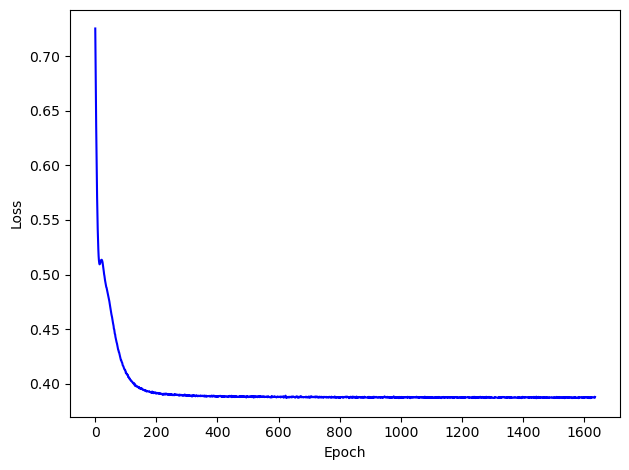

In [13]:
train_indices = np.arange(len(train_losses))
fig = plt.figure()
plt.plot(train_indices, train_losses, c='blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig.tight_layout()

In [14]:
# save IRT parameters to matrix
if OUTNAME == 'IRT' and IRT_DIMS == 1:    
    #z_dict = model.get_embeddings(train_data.to(device))
    z_dict = output_dict['embedding_0']
    df_item['IRT1_difficulty'] = -z_dict['item']
    df_item['IRT1_discrimination'] = z_dict['offset']
    ability = z_dict['ability']
    df_edge['IRT1_ability'] = ability.ravel()
    
    aux_data = (df, df_student, df_item, df_edge, 
    train_losses, 
    train_edge_indices, val_edge_indices, test_edge_indices,
    data.cpu(), train_data.cpu(), val_data.cpu().cpu(), test_data.cpu(),
    unique_scales, unique_domains, unique_matdiff, 
    DATA_FILE)

    with open(f'./results/{OUTNAME}_{DATASET}_aux_data_IRT1.pkl', 'wb') as handle:
        pickle.dump(aux_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    df_item_clean = df_item.dropna(subset=['IRT_difficulty', 'IRT1_difficulty'])    
    
    fig = plt.figure()
    sns.scatterplot(x='IRT_difficulty', y='IRT1_difficulty', data=df_item, hue='scale')
    plt.title('Difficulty')
    print('Difficulty:', pearsonr(df_item_clean['IRT1_difficulty'], df_item_clean['IRT_difficulty']))
    
    edge_feat = train_data['student', 'responds', 'item'].edge_attr.detach().cpu().numpy()
    df_edge_clean = df_edge.dropna(subset=['IRT1_ability', 'ability', 'age'])
    fig = plt.figure()
    sns.scatterplot(x='age', y='IRT1_ability', data=df_edge_clean, hue='grade')
    plt.title('Age-Ability')
    
    fig = plt.figure()
    sns.scatterplot(x='grade', y='IRT1_ability', data=df_edge_clean, hue='age')
    plt.title('Grade-Ability')
    print('Age-Ability:', pearsonr(df_edge_clean['age'], df_edge_clean['IRT1_ability']))

    fig = plt.figure()
    sns.scatterplot(x='ability', y='IRT1_ability', data=df_edge_clean, hue='grade')
    plt.title('Ability')
    print('Ability:', pearsonr(df_edge_clean['ability'], df_edge_clean['IRT1_ability']))
    